In [47]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import cycle
from scipy import stats
import seaborn as sns

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## **Load the Dataset**.
<p> The pickle file is adapted from <a href="https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-half-precision-pickle"><strong>Lonnie</strong></a> which is a reduced version of the original dataset. This speeds up loading and minimizes memory exhaustion</p>

In [48]:
# train df
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')

## **EDA**
We explore the structure of the data, its characteristics, and relationships

In [49]:
train.head(5)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


The train dataframe has 300 anonymized features labelled f_0 to f_299, investments and targets at different times.

In [50]:
#  extracting the features of the df
n_features = 300
features = [f'f_{i}' for i in range(n_features)]

#### **Are there any nulls? What are the total number of observations?**
<a id="1"></a>

In [51]:
#  check the shape and NaNS

obs = train.shape[0]
print(f"number of observations: {obs}")
print(f"NaNs in the dataframe? {str(train.isnull().values.any())}")

number of observations: 3141410
NaNs in the dataframe? False


### **Investments & Observation size (Time)**
<a id='time_investments'></a>

All the investments have a total of 3141410 observations from the [cell](#1) above. We investigate if these observations are distributed equally among the investments. 

In [52]:
# the number of investment ids, and max available time ids
# the investment_id with highest number of timesteps

obs_by_asset = train.groupby(['investment_id'])['target'].count()
# number of unique investments
assets = train.investment_id.nunique()
time_steps =train.time_id.nunique()
print(f"number of investments: {assets}\nmax time steps: {time_steps}")
print(f"highest observation window: investement_id {np.argmax(obs_by_asset)} with {np.max(obs_by_asset)}")
print(f"lowest observation window: investement_id {np.argmin(obs_by_asset)} with {np.min(obs_by_asset)}")


number of investments: 3579
max time steps: 1211
highest observation window: investement_id 2027 with 1211
lowest observation window: investement_id 1334 with 2


There  are 3579 investments. Investment 1334 has the lowest observation time of 2 whereas investment 2027 has highest observation time of 1211.
Investment have different observation times and therefore the dataset is not balanced

#### **Quartile Distribution**

In [53]:
# finding the quartiles of the time steps 

obs_by_asset.quantile([0.25,0.5,0.75])



0.25     683.0
0.50    1009.0
0.75    1131.0
Name: target, dtype: float64

50% of the investments have time steps between 0 and 683 for lower quartile and 1131 and 1211 for Q3.
The rest are between median value of 1009 and Q3

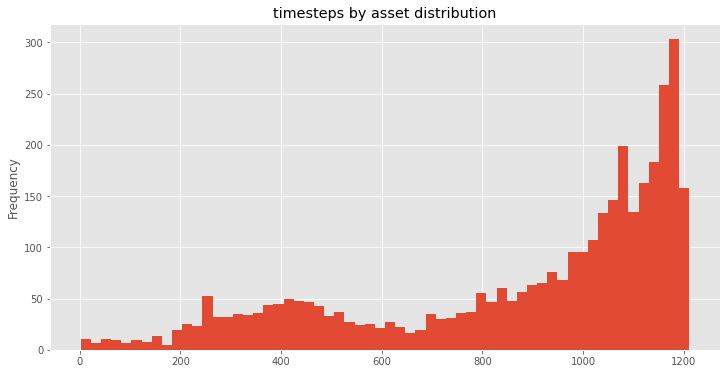

In [54]:
# visual rep of the sizes of observations

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
obs_by_asset.plot.hist(bins=60)
plt.title("timesteps by asset distribution")
plt.show()

The sample size of each investment is equal to the time steps used in recording the data. As computed in the previous cell, the majority of the investments have observations between 800 and 1200
<a id="2"></a>

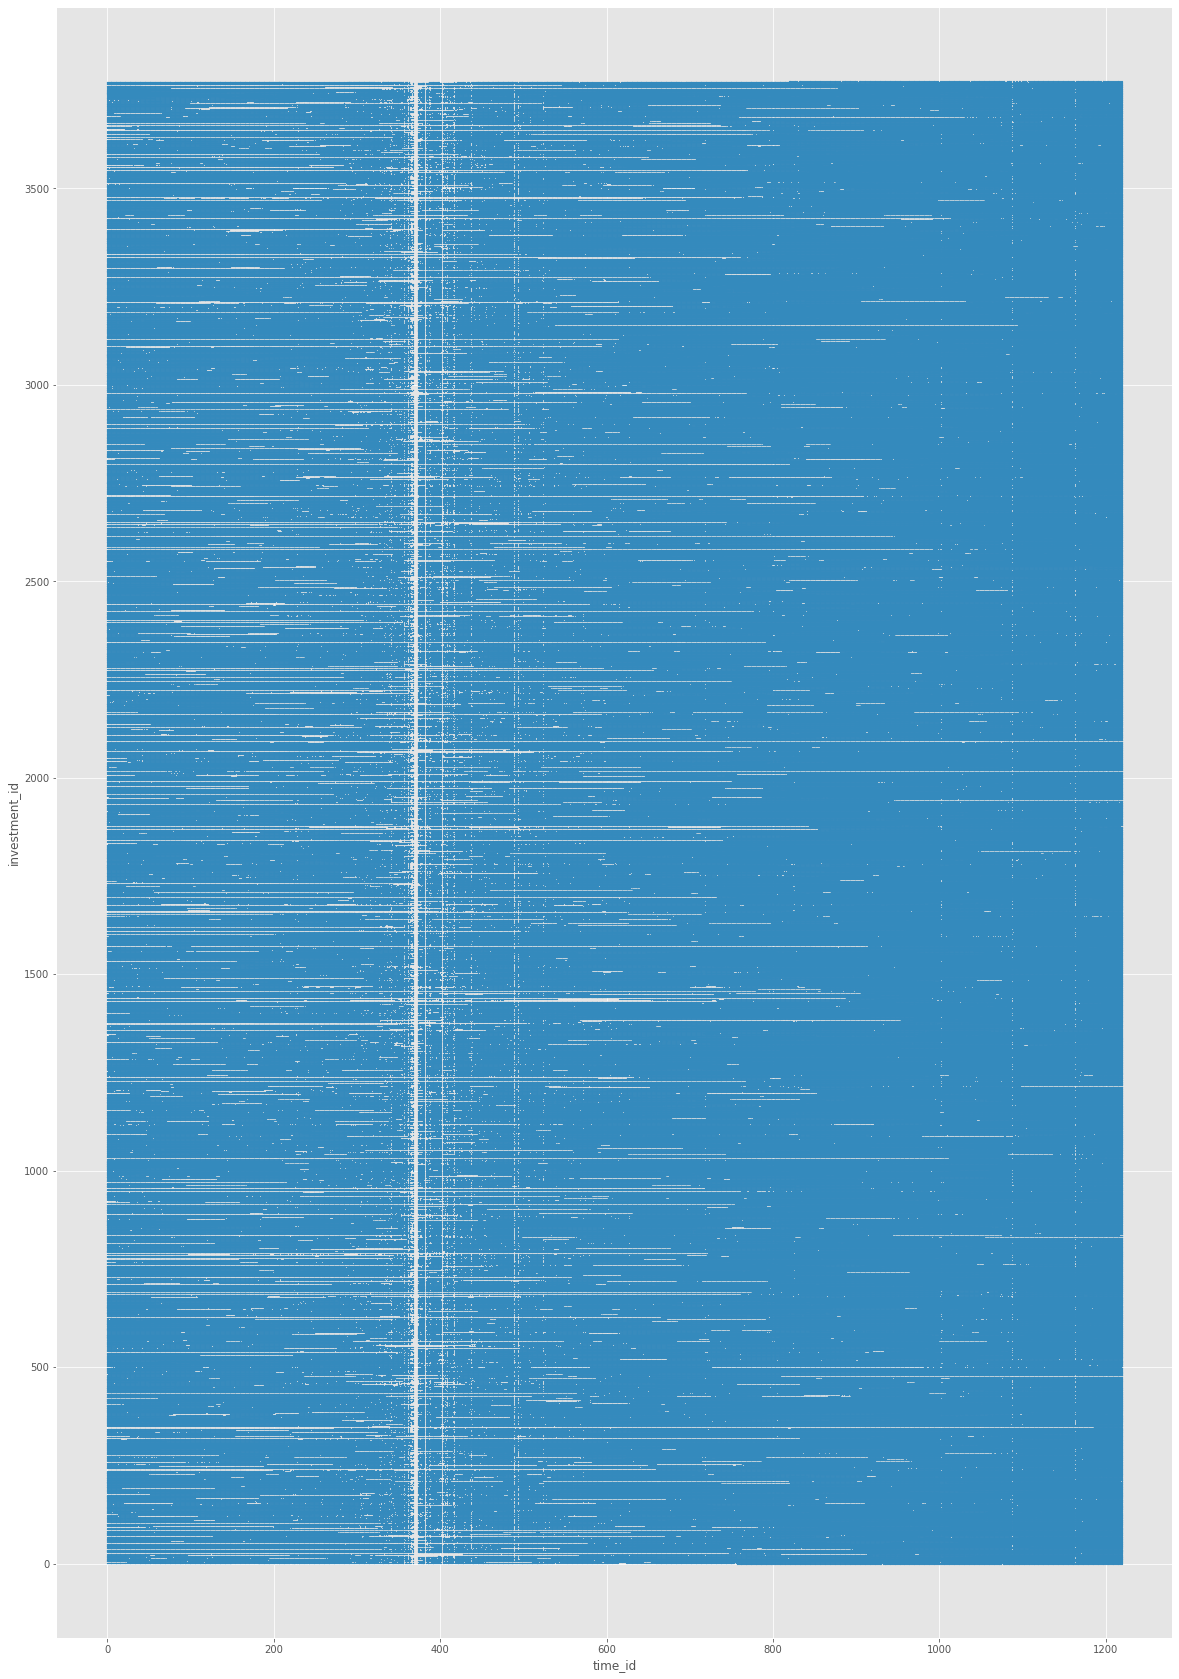

In [55]:
# we investigate the distribution of each investment observation across the min and the max time steps

train[['investment_id', 'time_id']].plot.scatter('time_id', 'investment_id', figsize=(20, 30), s=0.5)
plt.show()

The white patches shows missing data at the specific time id. The are some vertical white lines which are common across the various observations. These are probably holidays, missing or removed data.

### **Targets && Investment Ids**
<a id='targets_investments'></a>

We average the targets of each investment across the observation window. For each investment also, the standard deviation of targets is calculated.

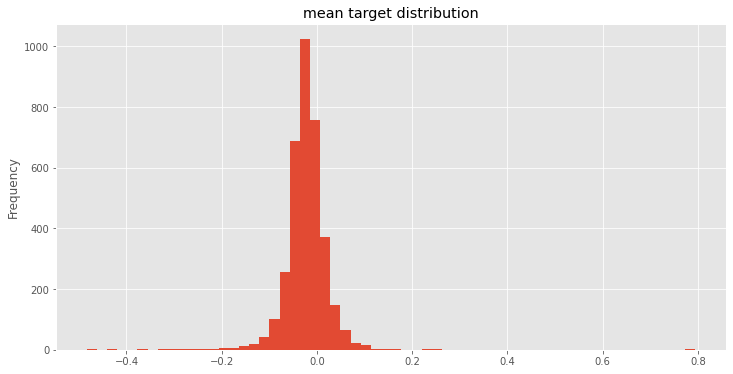

Mean of mean target: -0.02310


In [56]:
# The mean of the targets of each asset
mean_target = train.groupby(['investment_id'])['target'].mean()

# mean of the mean of each investment
mean_mean_target =mean_target.mean()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
mean_target.plot.hist(bins=60)
plt.title("mean target distribution")
plt.show()

print(f"Mean of mean target: {mean_mean_target: 0.5f}")

The distribution of targets is normal with a mean of almost zero. There are no outliers causing long tails, and can be used for modelling without further preprocessing

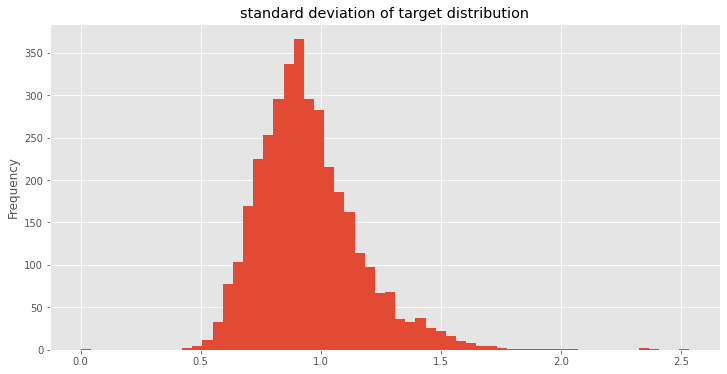

Mean of std target:  0.94790


In [57]:
# the standard deviation of the tragets of each investment id

sts_target = train.groupby(['investment_id'])['target'].std()

# the mean of the std of the targets
mean_std_target = np.mean(sts_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sts_target.plot.hist(bins=60)
plt.title("standard deviation of target distribution")
plt.show()

print(f"Mean of std target: {mean_std_target: 0.5f}")

The targets have a mean standard deviation of 0.9. Approximately 95% of the investments have a mean std between 0.5 and 1.5. There are a few data points with high STD

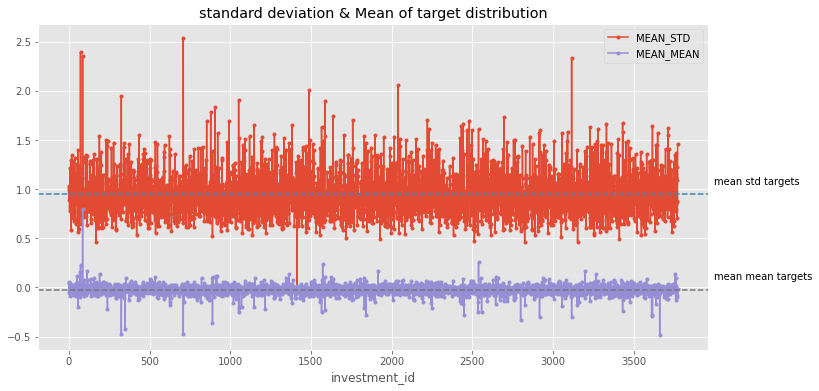

In [58]:
#  A plot of the std and the mean of each each asset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sts_target.plot(style='.-',color=next(color_cycle),legend=True,label='MEAN_STD')
ax.axhline(y=mean_std_target,linestyle='--',color=next(color_cycle))
ax.text(4000,mean_std_target+0.1,'mean std targets')

ax.text(4000,mean_mean_target+0.1,'mean mean targets')
mean_target.plot(style='.-',color=next(color_cycle),legend=True,label='MEAN_MEAN')
ax.axhline(y=mean_mean_target,linestyle='--',color=next(color_cycle))
plt.title("standard deviation & Mean of target distribution")
plt.show()

The plot of mean of asset targets is about zero, and confirm distribution of targets as normal. There a few cases of spiking in STD, and probably the reason for outliers in the distribution plot.

### **Time and Targets**
In this section, we are utilizing the observation size of each investment from [Investments & Time](#time_investments) and [Investment Targets](#targets_investments) to visualize the relationship of the time and the targets. We use Seaborn Joint plot library to compare how the mean and standard deviation of each investment target vary across time

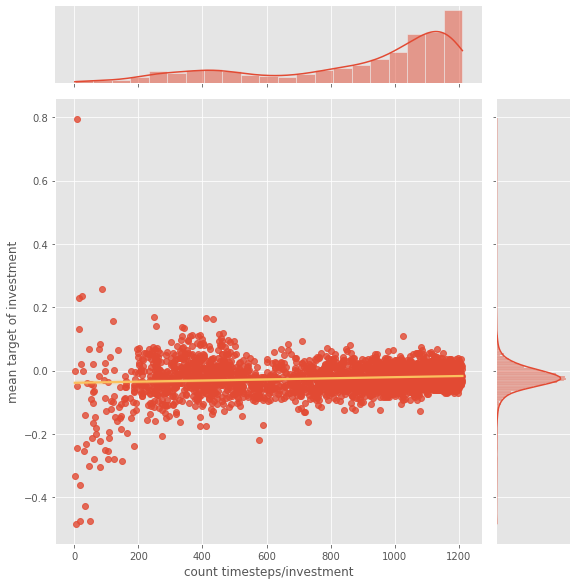

In [59]:
#  obs by target is a count of the time steps per investment id
#  A plot of mean of targets for each investment id

ax = sns.jointplot(x=obs_by_asset.values, y=mean_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':next(color_cycle)}})
ax.ax_joint.set_xlabel('count timesteps/investment')
ax.ax_joint.set_ylabel('mean target of investment')
plt.show()

The mean is constant for all the time ids. 

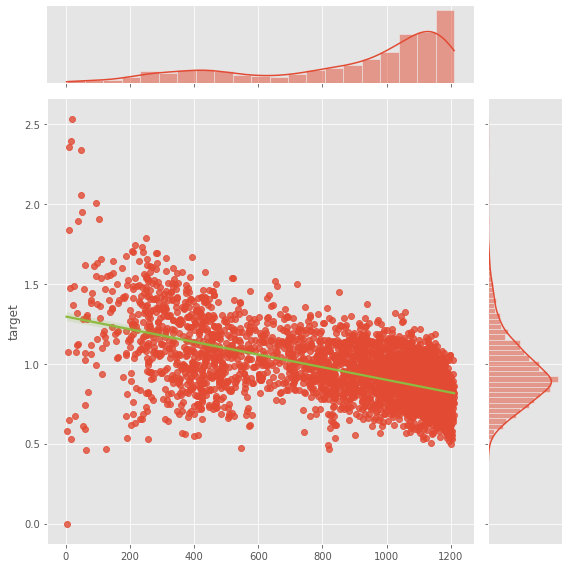

In [60]:
#  the count of investment time steps against mean std of each investment

qx = sns.jointplot(x=obs_by_asset.values, y=sts_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':next(color_cycle)}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('std target')
plt.show()

Time affects the mean standard deviation of the targets. It's obvious that the standard deviation reduces with increasing time steps
This is in contrast to the mean which is constant through the observation space.

#### **Is there any correlation between time and targets?**

In [61]:
#  we find the correlation of the time id and the targets

r = np.corrcoef(train.groupby('time_id')['investment_id'].nunique(), train.groupby('time_id')['target'].mean())[0][1]

print(f"Correlation of number of assets by target: {r:0.3f}")

Correlation of number of assets by target: -0.184


The coefficient is negative, and almost zero.Therefore, it can be concluded that there is no correlation.
In the next section, we will plot the mean and std of all the investments at different time windows.

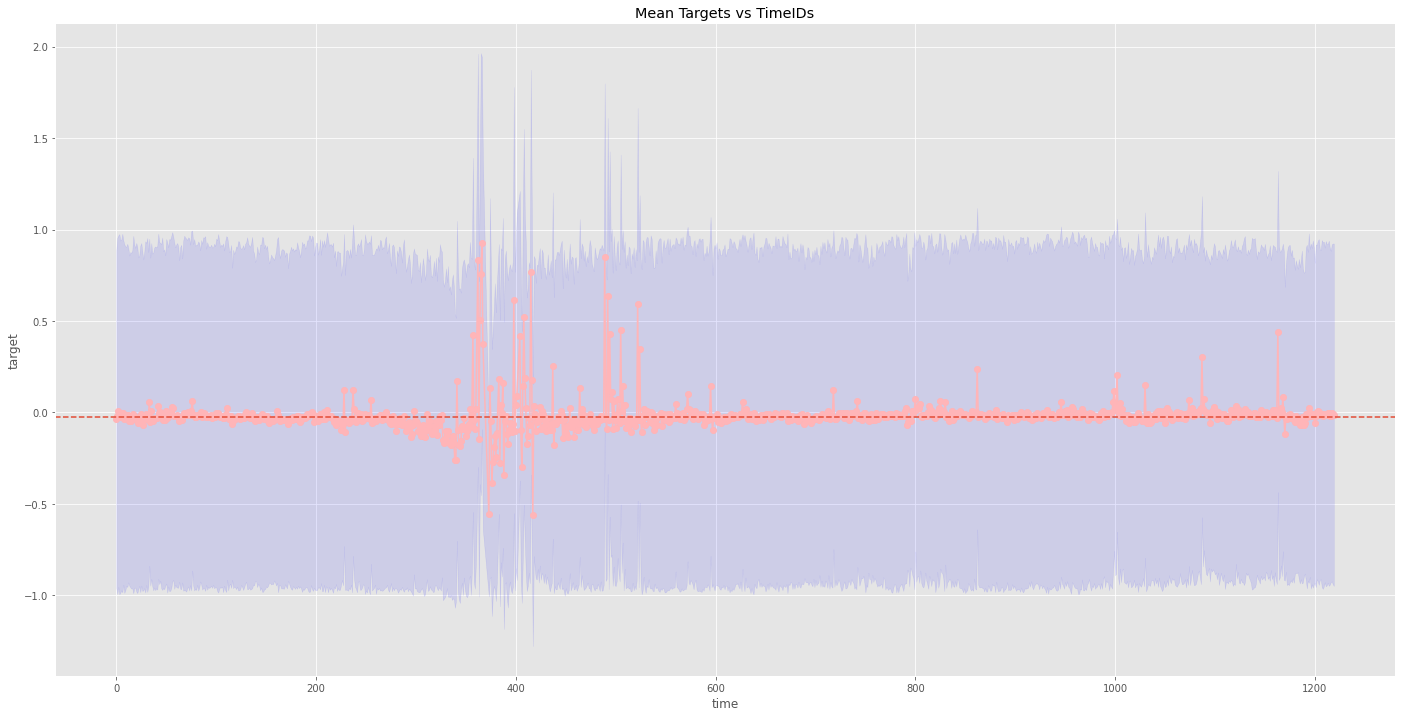

In [62]:
time2target_mean = train.groupby(['time_id'])['target'].mean() #mean of targets at specific time ids
time2target_std = train.groupby(['time_id'])['target'].std()  #std of targets at each time id

_, axes = plt.subplots(1, 1, figsize=(24, 12))

# fills the region between the minimum mean and maximum mean of the investments
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )

plt.plot(
        time2target_mean.index, time2target_mean, "o-", color=next(color_cycle), label="Training score"
    )
plt.axhline(y=mean_mean_target, color=next(color_cycle), linestyle='--', label="mean")
plt.title("Mean Targets vs TimeIDs")
axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

There is spiking in average of the mean between time id 380 to 500 compared to other regions where the target mean appear to be uniform. In this region, probably, there are missing data points for the majority of the investment ids. The white patches in the scatter plot [here](#2) concides with the spikes in this plot. It's the evidence of missing data.

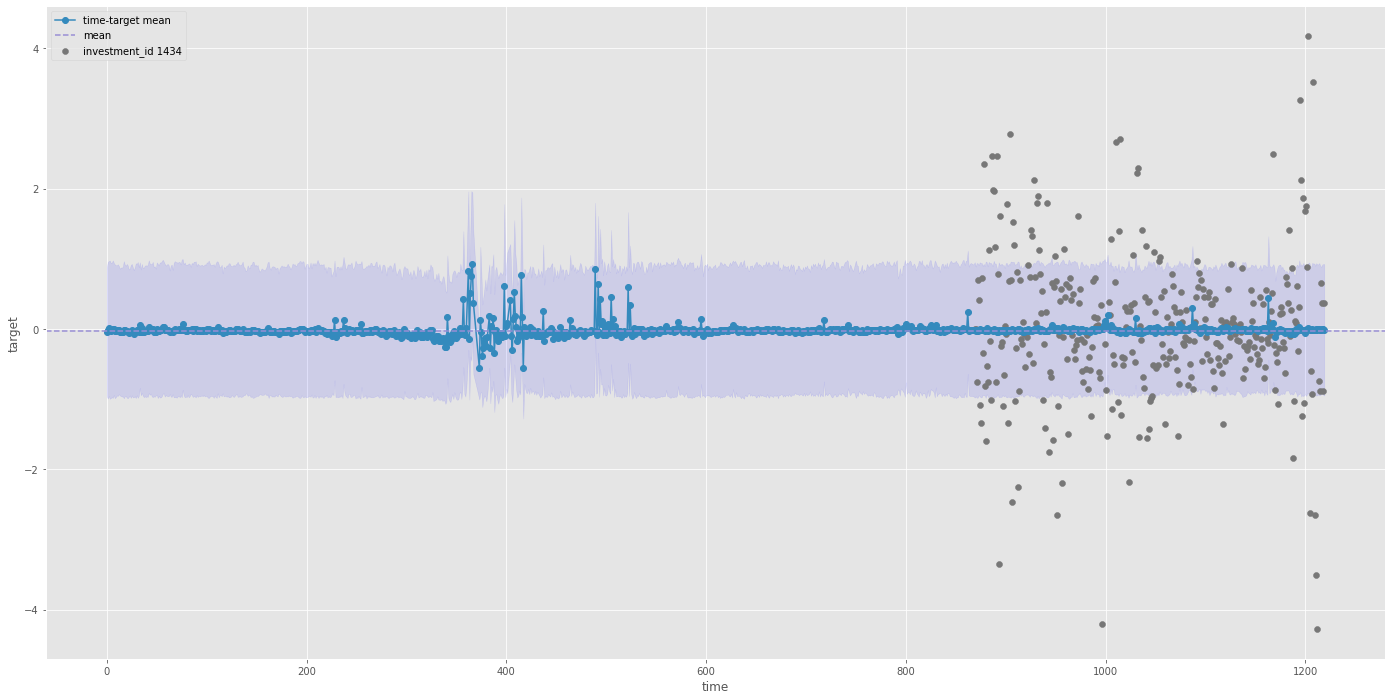

In [63]:
# a random investment id is 
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color=next(color_cycle), label="time-target mean"
    )
plt.axhline(y=mean_mean_target, color=next(color_cycle), linestyle='--', label="mean")

asset = np.random.randint(0,train.investment_id.nunique())
plt.scatter(train[train.investment_id==asset].time_id,
               train[train.investment_id==asset].target, color=next(color_cycle),label=f'investment_id {asset}')
plt.legend()

axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

A random investment is scattered along the mean-target-time plot. For the next section, we inspect specific investments, and how time affects it's targets

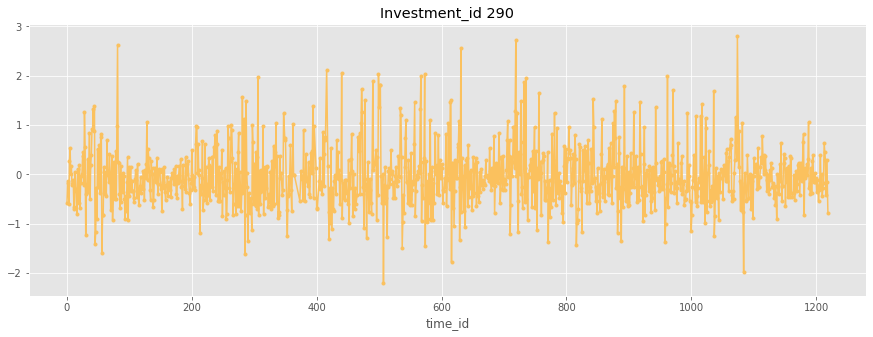

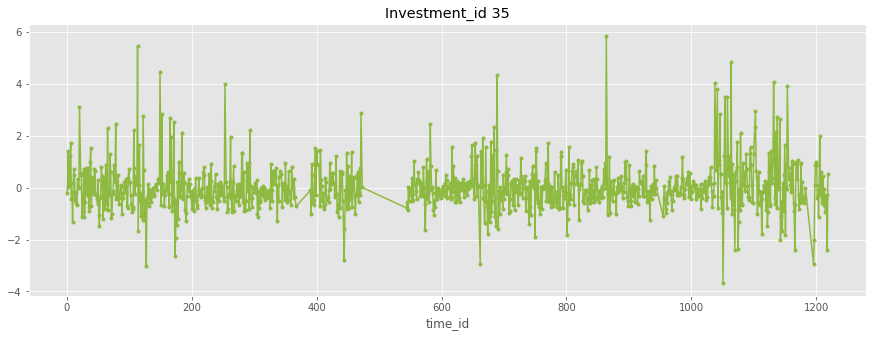

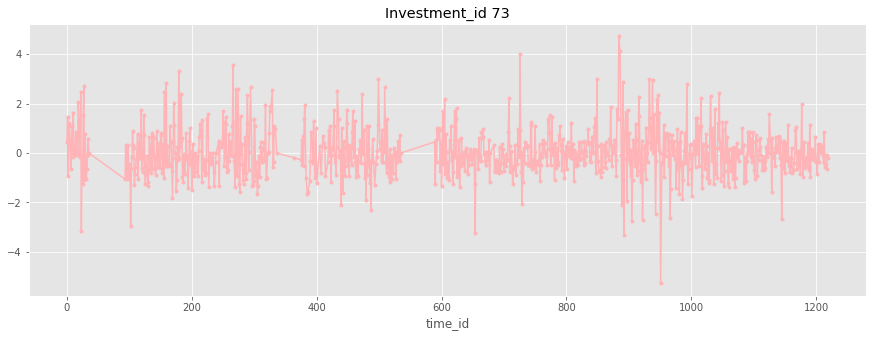

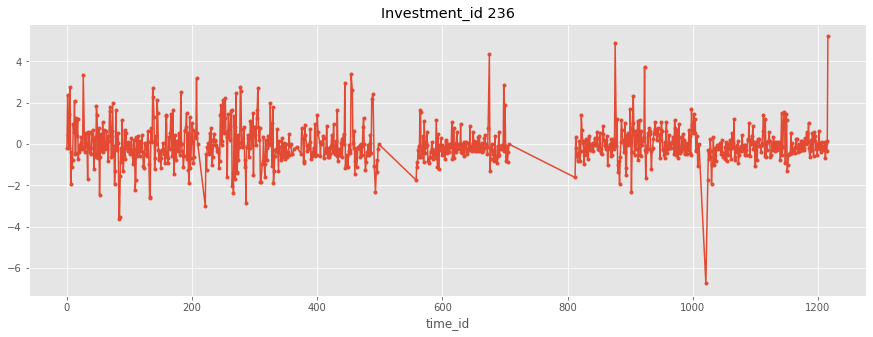

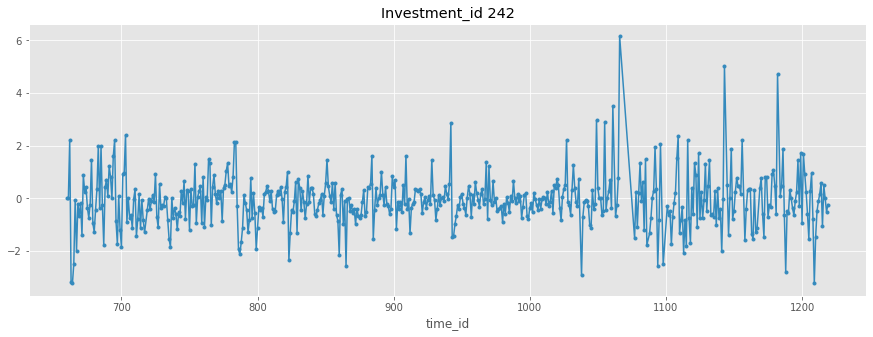

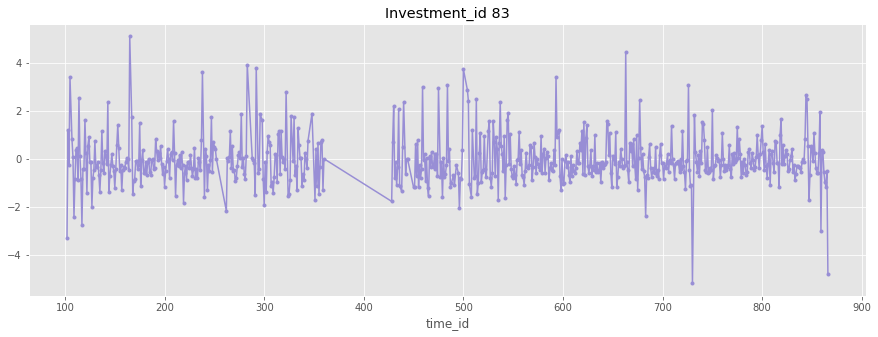

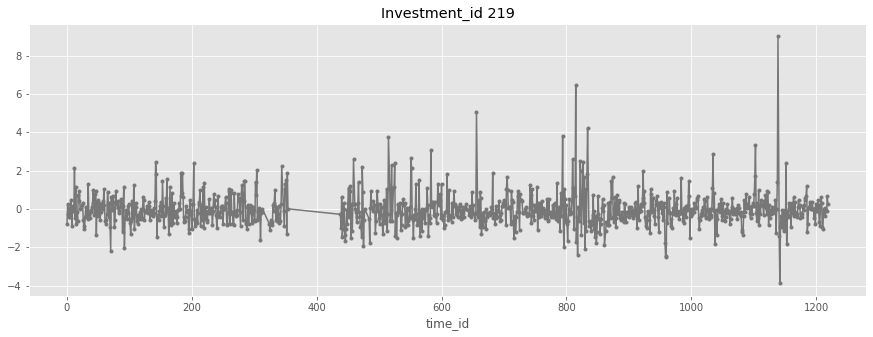

In [64]:
# we are plotting the random investment ids against time ids

random_investments = set(list(np.random.randint(0,300) for num in range(7)))

for investment_id in random_investments:
    d = train.query('investment_id == @investment_id')
    d.set_index('time_id')['target'] \
        .plot(figsize=(15, 5),
              title=f'Investment_id {investment_id}',
              color=next(color_cycle),
              style='.-')
    plt.show()

The plots of random assets indicate missing data and gaps in the observation window. Some of them such as investment 262 has completely no data points. The missing points will impede model performance in the training section. Investment 109 is selected to demonstrate these data gaps

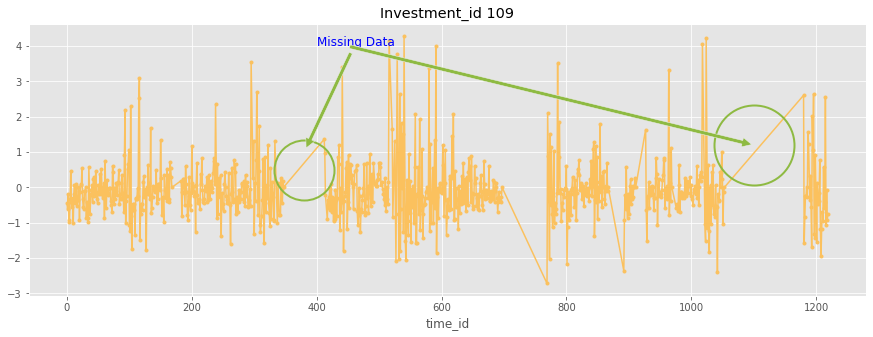

In [65]:
from matplotlib.patches import Ellipse
# a plot of investment_id 59
investment_id=109

fig, ax = plt.subplots(1, 1,figsize=(15, 5))
d = train.query('investment_id == @investment_id')

d.set_index('time_id')['target'] \
    .plot(title=f'Investment_id {investment_id}',
          color=next(color_cycle),
          style='.-')

circle_rad = 30  # This is the radius, in points
circle_2 = 40
color = next(color_cycle)
ax.plot(380, 0.5, 'o',
        ms=circle_rad * 2, mec=color, mfc='none', mew=2)
ax.annotate('Missing Data', xy=(380,1), xytext=(400, 4),
            color='b', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                facecolor=color, shrinkB=circle_rad * 0.15))
ax.plot(1100, 1.2, 'o',
        ms=circle_2 * 2, mec=color, mfc='none', mew=2)
ax.annotate('', xy=(1100,1.2), xytext=(450, 4),
            color='b', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                facecolor=color, shrinkB=circle_2 * 0.05))

plt.show()

### **Features**

There are 300 features whose values are anonymized. In the first section, we will plot the distribution of 30 features 

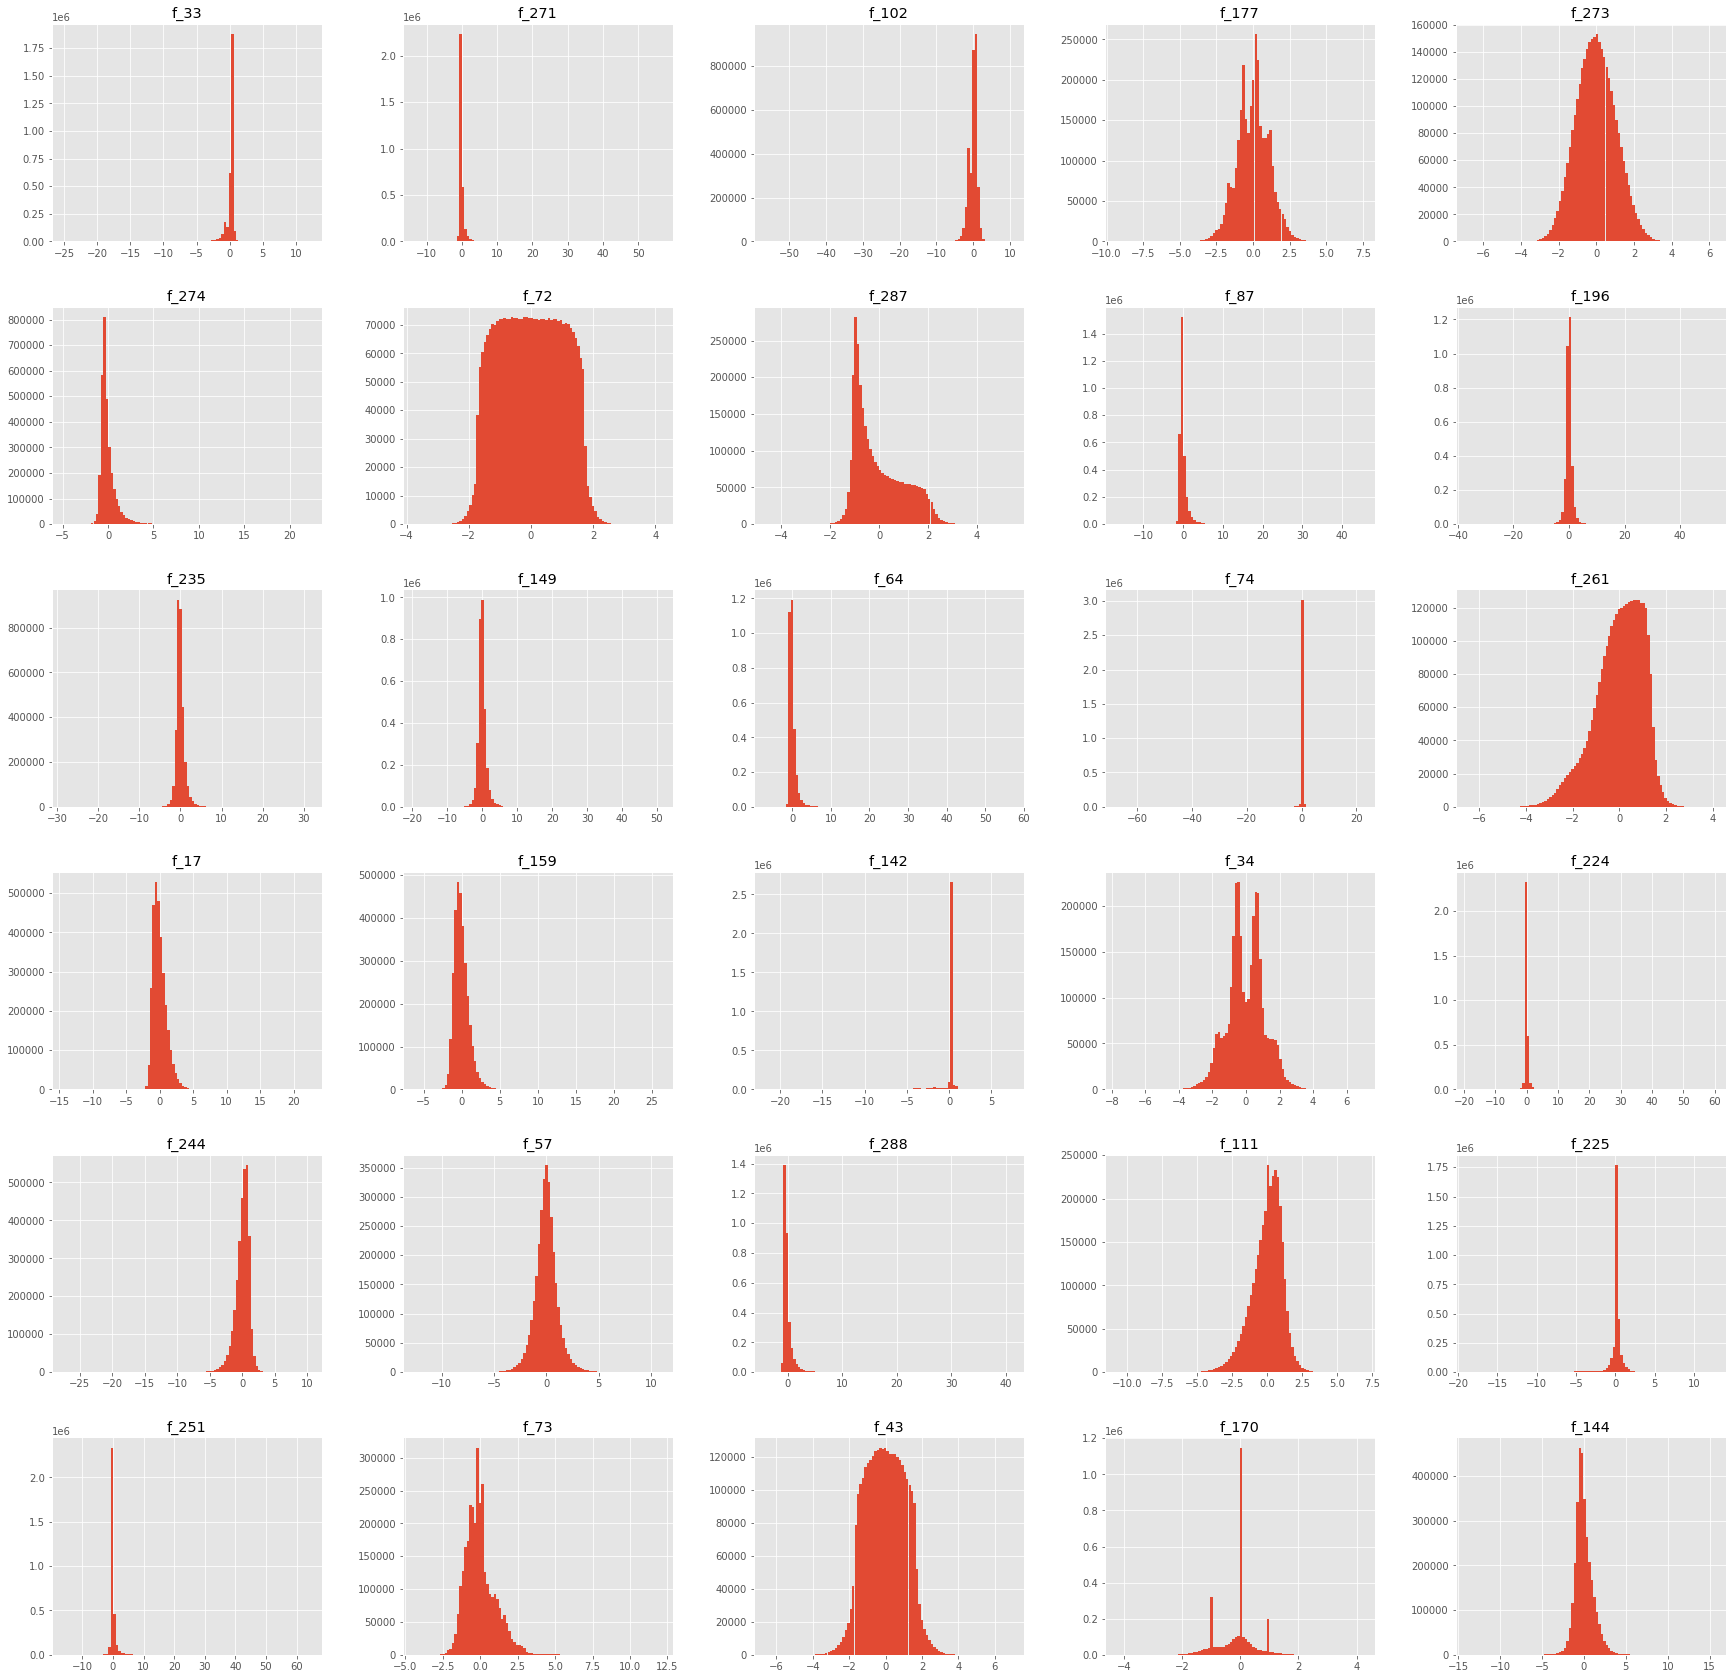

In [81]:
def plot_hist():
    '''Plot distribution of the features extracted randomly
    between 0 & 299
    
    '''

    columns = [f"f_{_}" for _ in np.random.choice(range(299), 30, replace=False)]
    train.hist(column = columns, bins = 100, figsize = (30,30))
    plt.show()

    return

plot_hist()


Its difficult to make sense of the histograms of the features. There are some which exhibit a normal distribution, some which are highly skewed with long tails, and multimodal(non-uniform) distribution.
What is conspicous also is missing data points.

In [67]:
# feature correlation



#### **features vs targets**
>First, is trending the random features vs targets to check for trends or correlation
<a id='3'></a>

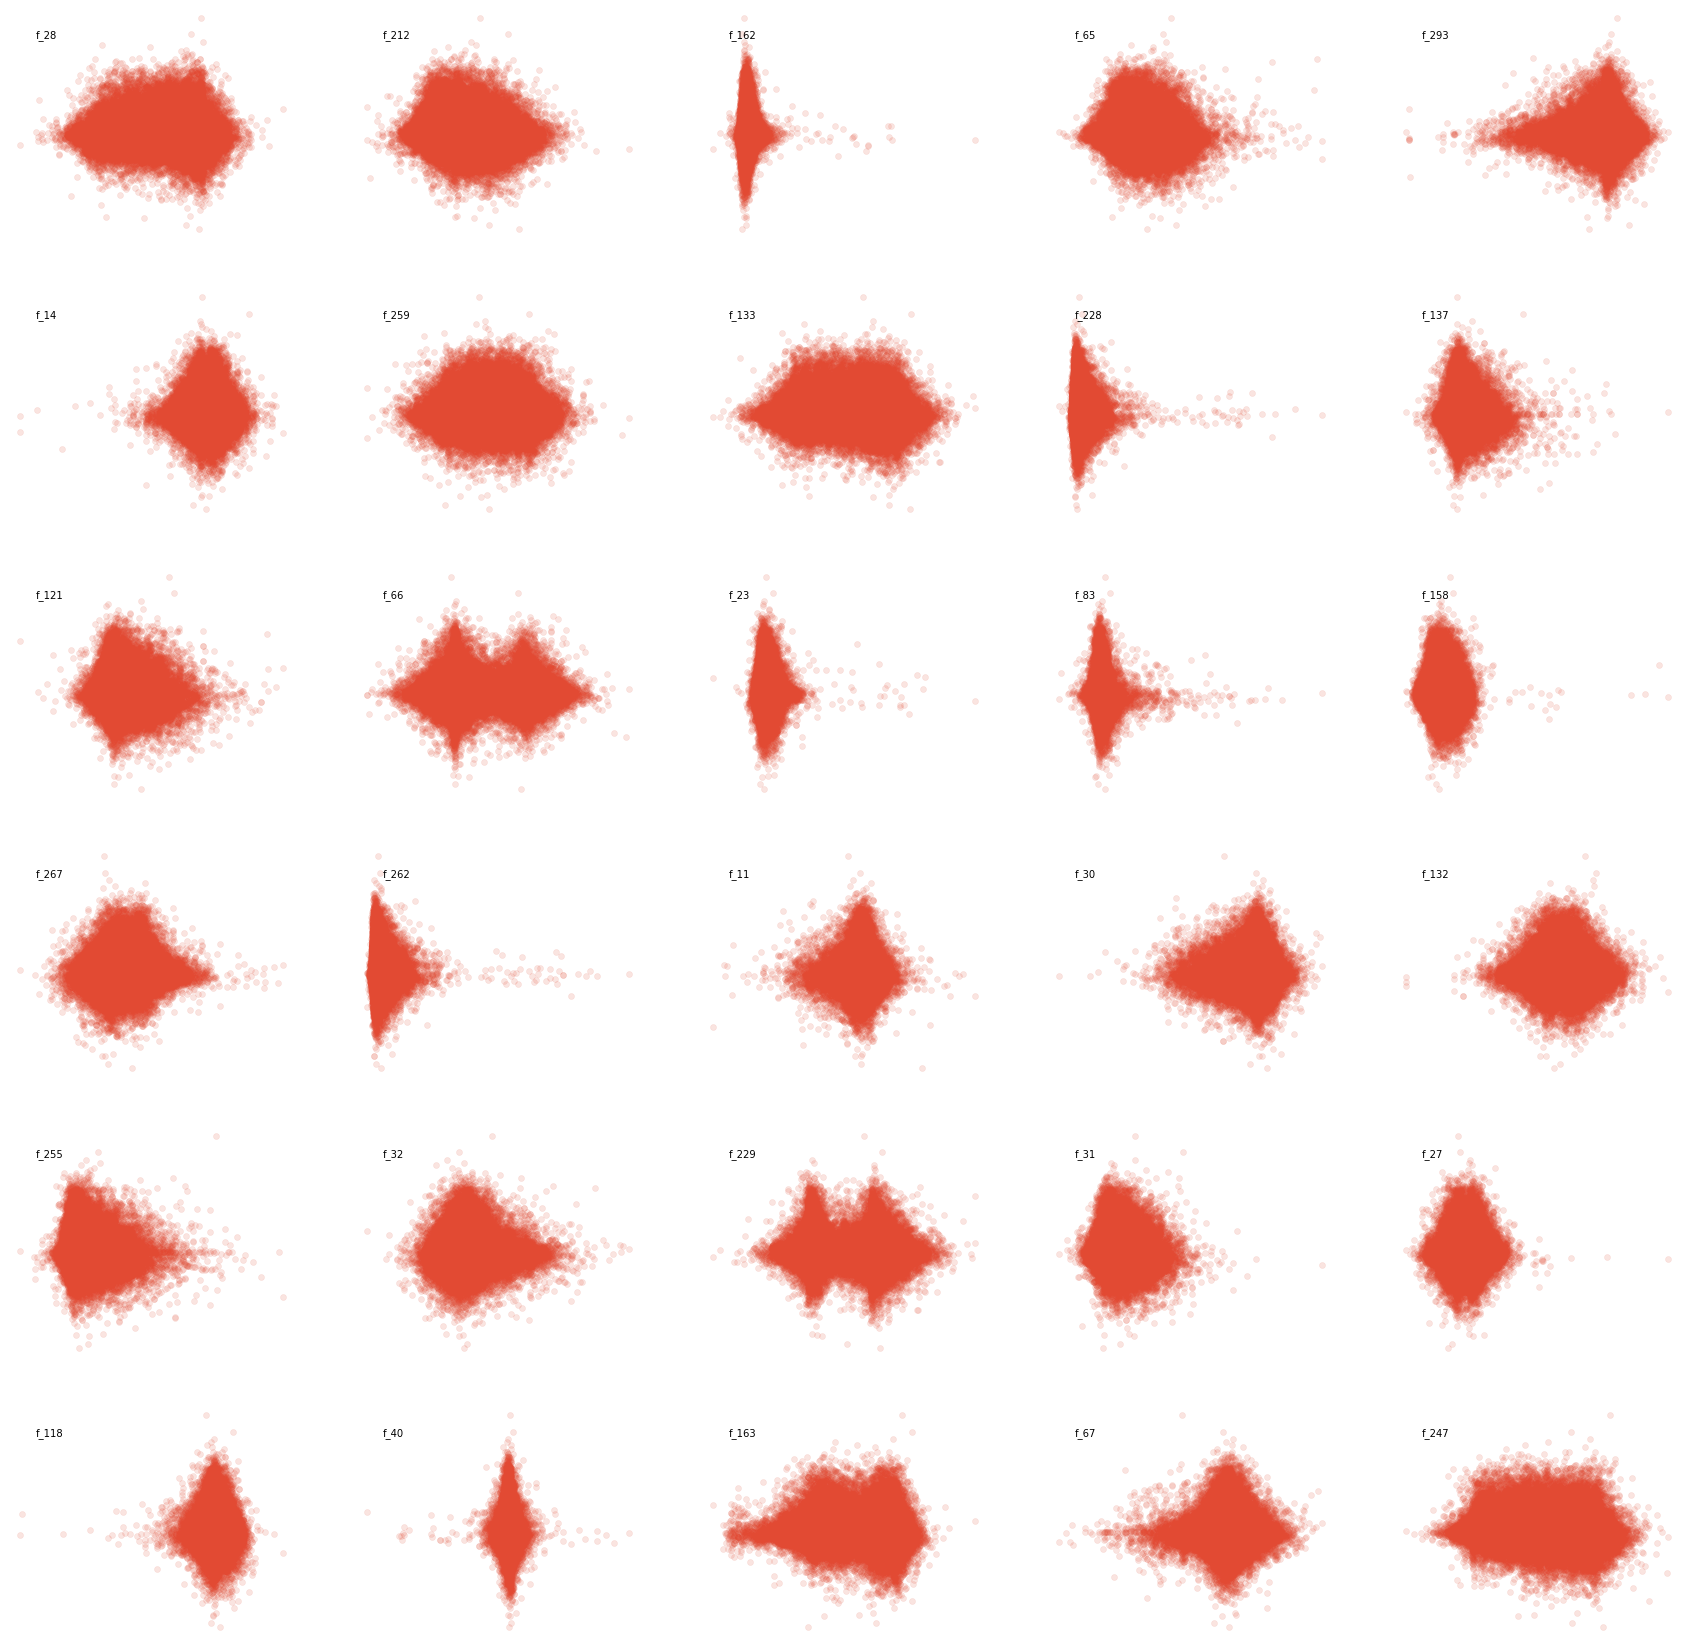

In [94]:
#  Using 3M+ observations will cause memory lag. Observations are sampled

target_sample = train.sample(frac = 0.10)

def target_feature():
    
    """
    This function randomly picks 30 features without replacement,
    and plot against the target.
    """
    
    fig, ax = plt.subplots(6, 5, figsize=(30,30), sharey=True)
    
    axes = [axis for axis in ax.flatten()]
    
    for i, _ in enumerate(np.random.choice(range(299), 30, replace=False)):
        ax_ = axes[i]

        df_ = target_sample[['target',f'f_{_}']]
        ax_.scatter(df_[f'f_{_}'], df_['target'], alpha=0.15)
        ax_.get_xaxis().set_visible(False)
        ax_.get_yaxis().set_visible(False)
        ax_.axis('off')
        plt.text(
            0.1,
            0.9,
            f'f_{_}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax_.transAxes)
        del df_
    plt.show()

target_feature()

The scatter plots appear as noise, and there seems to be no visible trends among the features and targets. We are then going to compute the correlation of the features and targets.

In [96]:
# correlation of features && targets

correlation = target_sample[['target']+features].corr()

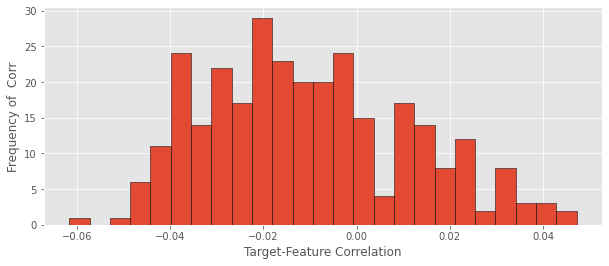

In [100]:
# 
fig, ax = plt.subplots(1,1,figsize=(10, 4))

plt.hist(correlation["target"][1:], edgecolor = "black", bins = 25)
ax.set_ylabel("Frequency of  Corr")
ax.set_xlabel("Target-Feature Correlation")
plt.show()

There seems to be a no strong linear correlation between the features and the target. Max positive corr is 0.04, and the min is -0.06. Feature-target plots [here](#3) had shown no trend  between the targets and features.

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


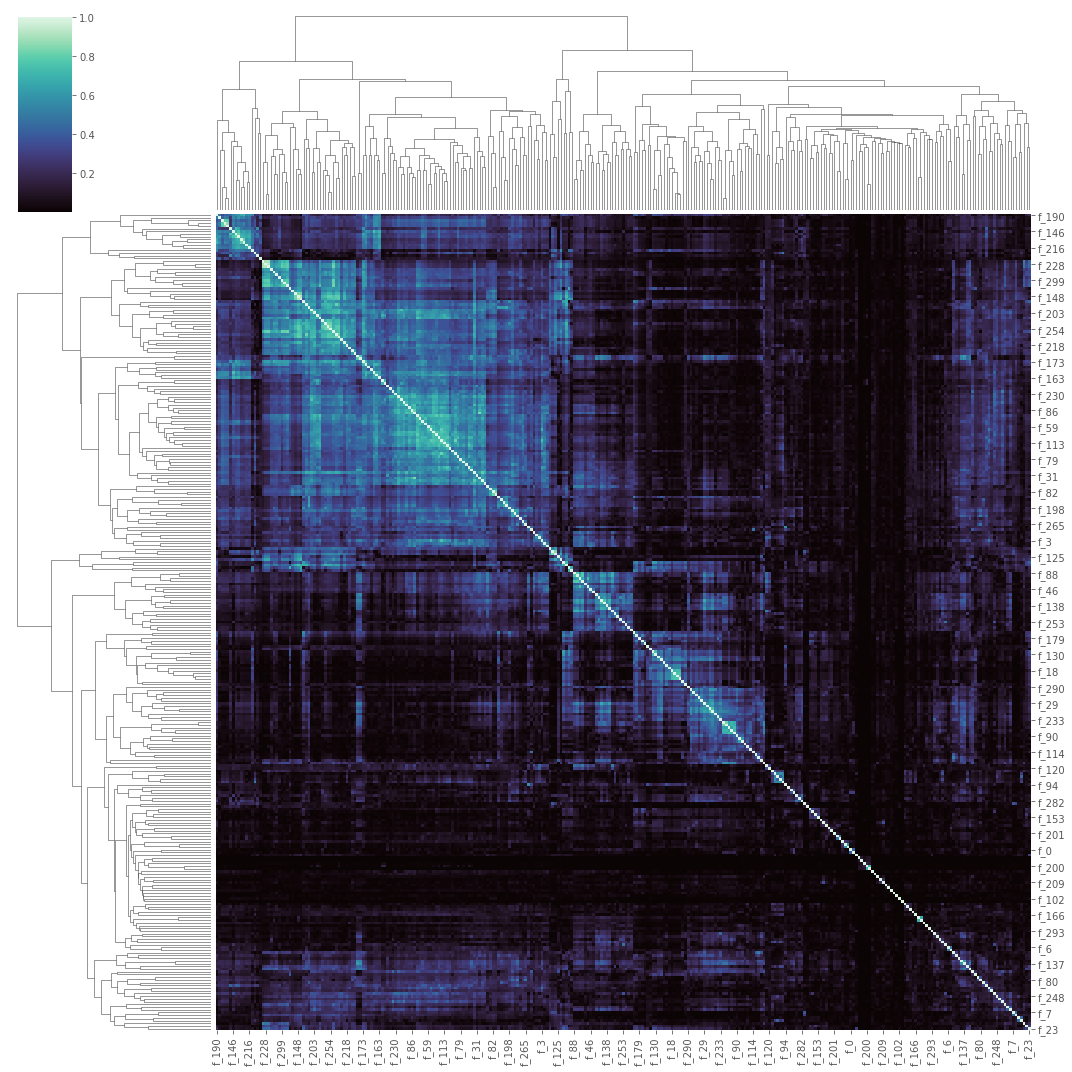

In [101]:
sns.clustermap(abs(correlation), figsize = (15,15), cmap = "mako");

Looking at the linear correlation between the fx features, we can see that there are several highly correlated features. Highly correlated features often contain the same information and we could drop some features without information loss.

### **Checking whether the data is static or not**
We are testing whether the data is stationary or not using the Augmented Dickey-Fuller test (ADF Test). Stationarity refers to a series which doesn't exhibit seasonality or a trend. The data properties such as mean, variance, covariance are independent and not a function of time.
ADF is conducted with the following assumptions:
* `Null Hypothesis` - *Data is non Stationary*
* `Alternate Hypothesis` - *Data is stationary*

Null hypothesis is adopted if the test static is less than the critical value, and p-value is less than 0.05


For investment of id 70, we reject null hypothesis for alternate hypothesis. The time series is stationary from the p-value which is less than the significance level of 0.05, and the ADF statistic is less than any critical values

In [69]:
#  we perform ADF tests for more random investment ids

for i in range(5):
    asset = np.random.randint(0,train.investment_id.nunique())
    d = train.query('investment_id == @asset')
    d = d.set_index('time_id')['target']
    
    
    try:
        adf_test(d,asset)
    except err:
        print(err)
        pass

Results of Dickey-Fuller Test: Investment_id 2157:
Test Statistic                  -18.927587
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1152.000000
Critical Value (1%)              -3.436039
Critical Value (5%)              -2.864052
Critical Value (10%)             -2.568108
dtype: float64


Results of Dickey-Fuller Test: Investment_id 1499:
Test Statistic                -1.526841e+01
p-value                        4.753990e-28
#Lags Used                     4.000000e+00
Number of Observations Used    1.134000e+03
Critical Value (1%)           -3.436130e+00
Critical Value (5%)           -2.864092e+00
Critical Value (10%)          -2.568129e+00
dtype: float64


Results of Dickey-Fuller Test: Investment_id 3105:
Test Statistic                 -20.878687
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    792.000000
Critical Value (1%)             -3.4

Random investments tested above satisfy the ADF criteria for time stationarity. It can be concluded therefore that the assets in this dataset are stationary.